# Parametrization of axis-symmetric bubbles shapes - simple shapes

Four bubbles are investigated:
- bubbles in aqueous sugar solutions (Bhaga & Weber 1981)
    - spherical cap (closed wake) $Eo=115$, $Mo=4.63\times 10^{-3}$, $Ga^\prime = 135$
- small bubbles in water at 20°C, $Mo=2.5728\times 10^{-11}$
    - $d_{eq}=1.0~mm$ corresponding to $Eo=0.1346$, $Ga^\prime = 98.672$
    - $d_{eq}=1.4~mm$ corresponding to $Eo=0.2638$, $Ga^\prime = 163.45$
    - $d_{eq}=1.8~mm$ corresponding to $Eo=0.4361$, $Ga^\prime = 238.29$
    
The goal is to parametrize the bubbles shapes and then to export the shape to a geometry file that can be used by one of the standard OpenFOAM meshers. Star-shaped bubbles are described as spatially varying radius. Itersections of the piecewise linear interface reconstruction with the underlying background mesh are called *PLIC points* hereafter.

The main steps are:
1. select time instances and select corresponding iteration/bubble center/PLIC points
2. read PLIC points from disk and convert them to a polar coordinate system with the orgin being the (geometrical) bubble center
3. train a neural network to learn a representation of the shape
4. use the network to create a 2D STL file

## Load facets for given time instances

In [1]:
import copy
import glob
import helper_module as hm
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.neighbors import KernelDensity
import torch

%matplotlib inline


data_path = "../data/"
names = ["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]
times = [30, 12, 14, 14]
output_path = "../output/models"
!mkdir -p ../output/models
!mkdir -p ../output/STL

cases = [data_path + name for name in names]

for i, case in enumerate(cases):
    print(i, case, times[i])

0 ../data/bhaga_03_l16 30
1 ../data/water_01_l16 12
2 ../data/water_03_l16 14
3 ../data/water_05_l16 14


In [2]:
all_facets = {}
for i, case in enumerate(cases):
    log_path = case + "/log." + names[i] + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'x'])
    row = log.find_closest("time", times[i])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[names[i]] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)

Successfully read file ../data/bhaga_03_l16/log.bhaga_03_l16.csv
Successfully read file ../data/bhaga_03_l16/plic_clean/plic_089590.pkl
Successfully read file ../data/water_01_l16/log.water_01_l16.csv
Successfully read file ../data/water_01_l16/plic_clean/plic_1045900.pkl
Successfully read file ../data/water_03_l16/log.water_03_l16.csv
Successfully read file ../data/water_03_l16/plic_clean/plic_871610.pkl
Successfully read file ../data/water_05_l16/log.water_05_l16.csv
Successfully read file ../data/water_05_l16/plic_clean/plic_677920.pkl


## Plot facets in polar coordinates

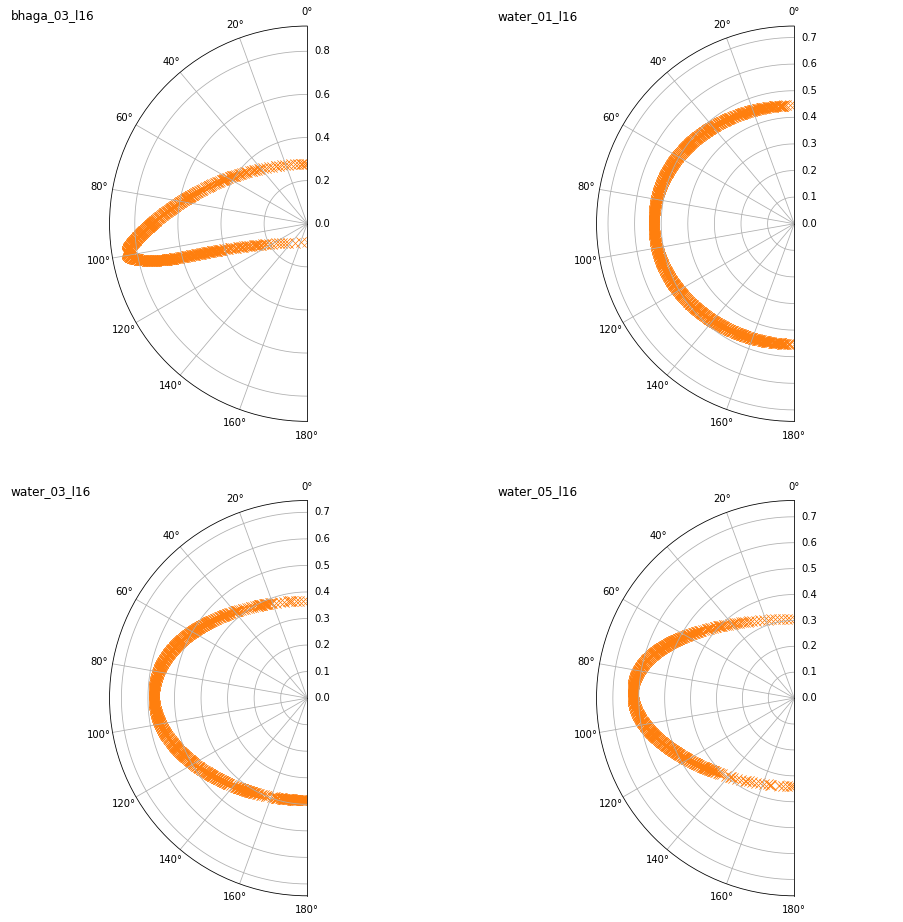

In [3]:
rc('text', usetex=False)
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 16), subplot_kw=dict(projection='polar'))

idt = [(i, j) for i in [0, 1] for j in [0, 1]]

for i, name in enumerate(names):
    row, col = idt[i]
    rad, phi = all_facets[name].get_facets(polar=True)
    axarr[row, col].scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5)
    axarr[row, col].set_theta_zero_location("N")
    axarr[row, col].set_xlim(0.0, np.pi)
    axarr[row, col].set_title(name, loc='left')

## Approximate shapes

In [4]:
def training_loop(model, path, x_train, y_train, y_weight, epochs, l_rate):
    """Optimize the weights of a given MLP.
    
    Parameters
    ----------
    model - SimpleMLP : model to optimize
    path - String : path to save best model weights
    x_train - array-like : feature vector of dimension [n_samples, n_features]
    y_train - array-like : label vector of dimension [n_samples, n_labels]
    y_weight - array-like : vector to put more weight on specific points in the training set; dimension [n_samples]
    epochs - Integer : number of epochs to train
    l_rate - Float : learning rate
    
    Returns
    -------
    history - List : loss developments over epochs
    model - SimpleMLP : opimized model in evaluation mode
    
    """
    if y_weight is None: y_weight = np.ones(x_train.shape[0])
    x_tensor = torch.from_numpy(x_train.astype(np.float64)).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y_train.astype(np.float64))
    y_weight_tensor = torch.from_numpy(y_weight.astype(np.float64))
    zero = torch.zeros(y_tensor.shape[0])
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)

    best_loss = 1.0E5
    train_loss = []

    for e in range(1, epochs+1):
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        diff = (output.squeeze(dim=1) - y_tensor) * y_weight_tensor
        loss = criterion(diff, zero)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), path)
    return model.eval(), np.asarray(train_loss)

In [5]:
# convinience function for saving plots as png and pdf
def savefig(name):
    output_path = "../output/"
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

### Test various activation functions on case bhaga_03_l16

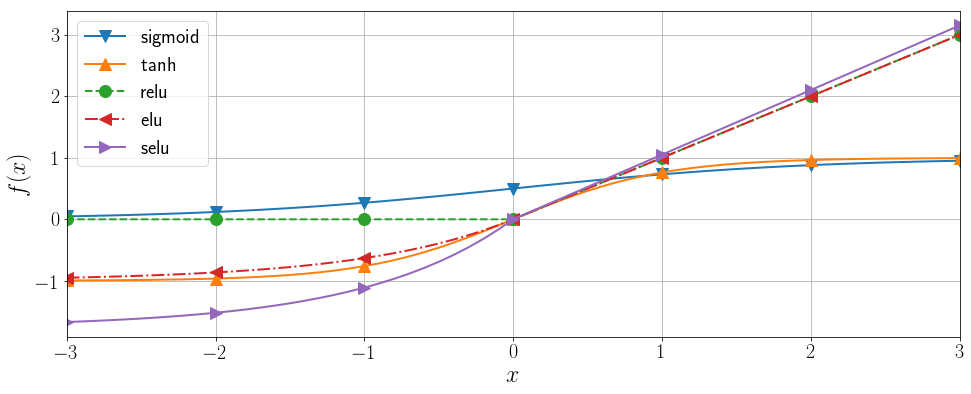

In [6]:
rc('text', usetex=True)
activations = [
    torch.sigmoid,
    torch.tanh,
    torch.nn.functional.relu,
    torch.nn.functional.elu,
    torch.nn.functional.selu
]

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

x = torch.arange(-3, 3.01, 0.1)

marker = ["v", "^", "o", "<", ">"]
ls = ["-", "-", "--", "-.", "-"]
for i, func in enumerate(activations):
    ax.plot(x, func(x), ls=ls[i], lw=2, marker=marker[i], ms=12, markevery=10, label=func.__name__)
ax.set_xlim(-3,3)
ax.set_xlabel("$x$", fontsize=hm.fontsize_label)
ax.set_ylabel("$f(x)$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.grid(True)
ax.legend(fontsize=hm.fontsize_legend)
savefig("activation_functions")

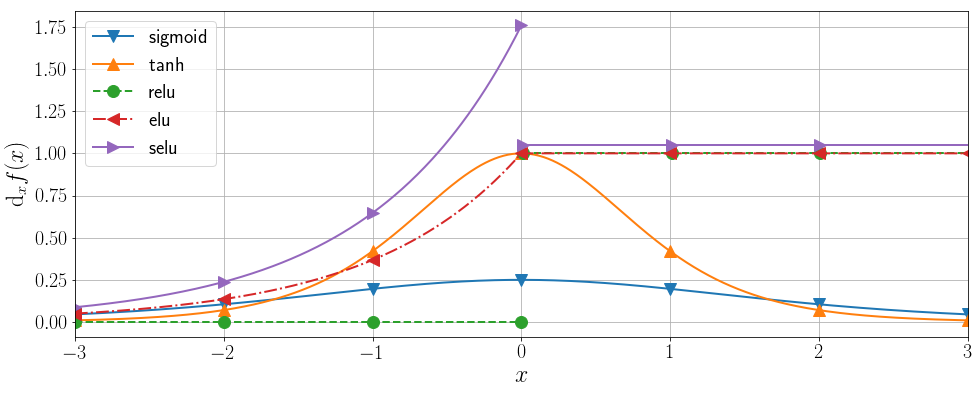

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

x = torch.autograd.Variable(torch.arange(-3, 3.01, 0.01), requires_grad=True)

marker = ["v", "^", "o", "<", ">"]
ls = ["-", "-", "--", "-.", "-"]
cont = [True, True, False, True, False]
color = ["C{:1d}".format(i) for i in range(len(activations))]
for i, func in enumerate(activations):
    res = func(x)
    res.backward(torch.ones(x.shape[0]))
    x_num = x.detach().numpy()
    grad_num =  x.grad.numpy()
    if cont[i]:
        ax.plot(x_num, grad_num,
            ls=ls[i], lw=2, marker=marker[i], ms=12, markevery=100, color=color[i], label=func.__name__)
    else:
        ax.plot([xi for xi in x_num if xi <= 0.0], [dx for xi, dx in zip(x_num, grad_num) if xi <= 0.0],
                ls=ls[i], lw=2, marker=marker[i], ms=12, markevery=100, color=color[i], label=func.__name__)
        ax.plot([xi for xi in x_num if xi > 0.0], [dx for xi, dx in zip(x_num, grad_num) if xi > 0.0],
                ls=ls[i], lw=2, marker=marker[i], ms=12, color=color[i], markevery=100)
    x.grad.data.zero_()
    
ax.set_xlim(-3,3)
ax.set_xlabel("$x$", fontsize=hm.fontsize_label)
ax.set_ylabel("$\mathrm{d}_xf(x)$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.grid(True)
ax.legend(fontsize=hm.fontsize_legend)
savefig("activation_functions_derivative")

In [8]:
# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 6,
    "n_neurons" : 40,
    "activation" : None,
    "batch_norm" : False
}

all_losses = {}
all_models = {}
epochs = 2000

rad, phi = all_facets["bhaga_03_l16"].get_facets(polar=True)
for i, func in enumerate(activations):
    name = func.__name__
    print("Testing activation function \033[1m{}\033[0m".format(name))
    model_dict["activation"] = func
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/bhaga_03_l16_" + name + ".pt"
    model, losses = training_loop(model, model_path, phi, rad, None, epochs, 0.001)
    all_losses[name] = losses
    all_models[name] = copy.deepcopy(model)

Testing activation function sigmoid
Created model with 8321 weights.
Testing activation function tanh
Created model with 8321 weights.
Testing activation function relu
Created model with 8321 weights.
Testing activation function elu
Created model with 8321 weights.
Testing activation function selu
Created model with 8321 weights.


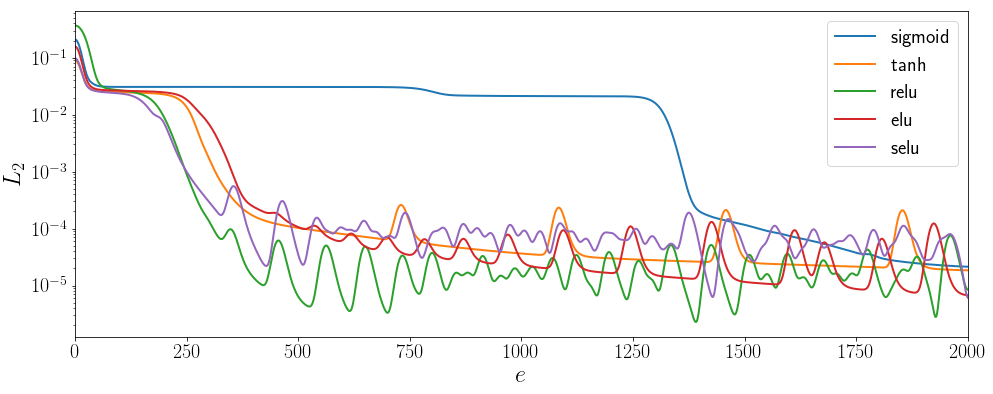

In [9]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

colors = ["C{:1d}".format(i) for i in range(5)]

for i, key in enumerate(all_losses.keys()):
    smoothed = gaussian_filter1d(all_losses[key], sigma=10)
    ax.plot(range(1, epochs+1), smoothed, ls="-", lw=2, color=colors[i], label=key)
    
ax.set_xlabel("$e$", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)
savefig("bhaga_03_loss_activations")

Created model with 8321 weights.
Created model with 8321 weights.
Created model with 8321 weights.
Created model with 8321 weights.
Created model with 8321 weights.

activation / L_2 / L_1/ L_max / L_max_rel
sigmoid   : 2.1282e-05, 0.002785, 0.037736, 0.436310
tanh      : 1.8429e-05, 0.003380, 0.009754, 0.029111
relu      : 4.4177e-07, 0.000505, 0.003767, 0.043556
elu       : 6.5666e-06, 0.001886, 0.019025, 0.219966
selu      : 4.3467e-07, 0.000541, 0.003436, 0.034679

Maximum PLIC offset abs/rel: 9.7036e-05/5.6444e-04
Average PLIC offset abs/rel: 2.0471e-06/4.5652e-06


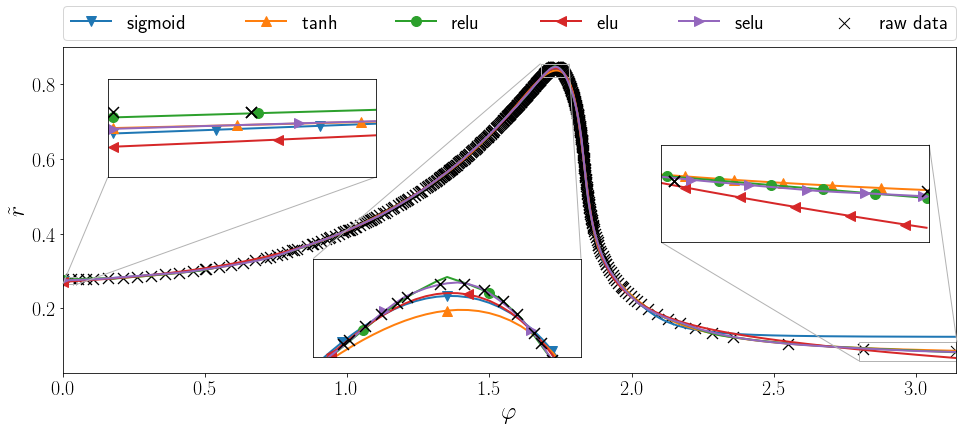

In [10]:
# statistics and plot
rad, phi = all_facets["bhaga_03_l16"].get_facets(polar=True)

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
# zoom windows
zoom_1 = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=[-0.001, 0.05], ylim=[0.265, 0.285])
zoom_2 = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=[1.68, 1.78], ylim=[0.82, 0.855])
zoom_3 = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=[2.8, 3.145], ylim=[0.06, 0.11])

results = ""
lines = []
marker = ["v", "^", "o", "<", ">"]
markevery = [10, 11, 12, 13, 14]
for i, key in enumerate(all_models.keys()):
    model_dict["activation"] = activations[i]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/bhaga_03_l16_" + key + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    phi_eval = torch.from_numpy(phi.astype(np.float64)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    L2_min = np.min(all_losses[key])
    diff = np.absolute(rad - rad_eval)
    L_1 = np.mean(diff)
    L_max = np.max(diff)
    L_max_rel = np.max(diff/rad)
    results += "{:10s}: {:1.4e}, {:1.6f}, {:1.6f}, {:1.6f}\n".format(key, L2_min, L_1, L_max, L_max_rel)
    
    # plot
    phi_eval = torch.from_numpy(np.linspace(0, np.pi, 800).astype(np.float64)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    lines.append(ax.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=1000, label=key)[0])
    zoom_1.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=markevery[i]-5)
    zoom_2.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=markevery[i])
    zoom_3.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=markevery[i]+5)

# print some statistics
print("\nactivation / L_2 / L_1/ L_max / L_max_rel")
print(results)
# sort points by polar angle to compute offset between intersection points
# (offset between two PLIC elements cutting the same edge)
phi_order = np.argsort(phi)
phi_sorted = phi[phi_order]
rad_sorted = rad[phi_order]
plic_offset = np.absolute(rad_sorted - np.roll(rad_sorted, -1))[1:-2:2]
plic_offset_rel = np.absolute((rad_sorted - np.roll(rad_sorted, -1)) / rad_sorted)[1:-2:2]
print("Maximum PLIC offset abs/rel: {:4.4e}/{:4.4e}".format(np.max(plic_offset), np.max(plic_offset_rel)))
print("Average PLIC offset abs/rel: {:4.4e}/{:4.4e}".format(np.mean(plic_offset), np.mean(plic_offset_rel)))

# raw data and zoom
lines.append(ax.scatter(phi, rad, marker="x", color="k", s=120, lw=1.0, label="raw data"))
ip_1 = InsetPosition(ax, [0.05, 0.6, 0.3, 0.3])
ip_2 = InsetPosition(ax, [0.28, 0.05, 0.3, 0.3])
ip_3 = InsetPosition(ax, [0.67, 0.4, 0.3, 0.3])
zoom_1.set_axes_locator(ip_1)
zoom_2.set_axes_locator(ip_2)
zoom_3.set_axes_locator(ip_3)
mark_inset(ax, zoom_1, loc1=3, loc2=4, fc="none", ec='0.7')
mark_inset(ax, zoom_2, loc1=2, loc2=1, fc="none", ec='0.7')
mark_inset(ax, zoom_3, loc1=3, loc2=1, fc="none", ec='0.7')
zoom_1.scatter(phi, rad, marker="x", color="k", s=120, lw=1.5, zorder=6)
zoom_2.scatter(phi[::10], rad[::10], marker="x", color="k", s=120, lw=1.5, zorder=6)
zoom_3.scatter(phi, rad, marker="x", color="k", s=120, lw=1.5, zorder=6)

ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_xlim(0, np.pi)
ax.set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)

savefig("bhaga_03_radius_activations")

### Test various network architectures on case bhaga_03_l16

In [11]:
model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : None,
    "n_neurons" : None,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}
layers = range(1, 9)
nodes = range(20, 61, 10)

In [12]:
all_losses = {}
all_models = {}

epochs = 2000
rad, phi = all_facets["bhaga_03_l16"].get_facets(polar=True)
for n_layers in layers:
    for n_nodes in nodes:
        print("Testing MLP with \033[1m{} layer(s)\033[0m and \033[1m{} nodes\033[0m".format(n_layers, n_nodes))
        model_dict["n_layers"] = n_layers
        model_dict["n_neurons"] = n_nodes
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path + "/bhaga_03_l16_selu_{:1d}_layers_{:2d}_nodes.pt".format(n_layers, n_nodes)
        model, losses = training_loop(model, model_path, phi, rad, None, epochs, 0.001)
        all_losses[model_path] = losses
        all_models[model_path] = copy.deepcopy(model)

Testing MLP with 1 layer(s) and 20 nodes
Created model with 61 weights.
Testing MLP with 1 layer(s) and 30 nodes
Created model with 91 weights.
Testing MLP with 1 layer(s) and 40 nodes
Created model with 121 weights.
Testing MLP with 1 layer(s) and 50 nodes
Created model with 151 weights.
Testing MLP with 1 layer(s) and 60 nodes
Created model with 181 weights.
Testing MLP with 2 layer(s) and 20 nodes
Created model with 481 weights.
Testing MLP with 2 layer(s) and 30 nodes
Created model with 1021 weights.
Testing MLP with 2 layer(s) and 40 nodes
Created model with 1761 weights.
Testing MLP with 2 layer(s) and 50 nodes
Created model with 2701 weights.
Testing MLP with 2 layer(s) and 60 nodes
Created model with 3841 weights.
Testing MLP with 3 layer(s) and 20 nodes
Created model with 901 weights.
Testing MLP with 3 layer(s) and 30 nodes
Created model with 1951 weights.
Testing MLP with 3 layer(s) and 40 nodes
Created model with 3401 weights.
Testing MLP with 3 layer(s) and 50 nodes
Create

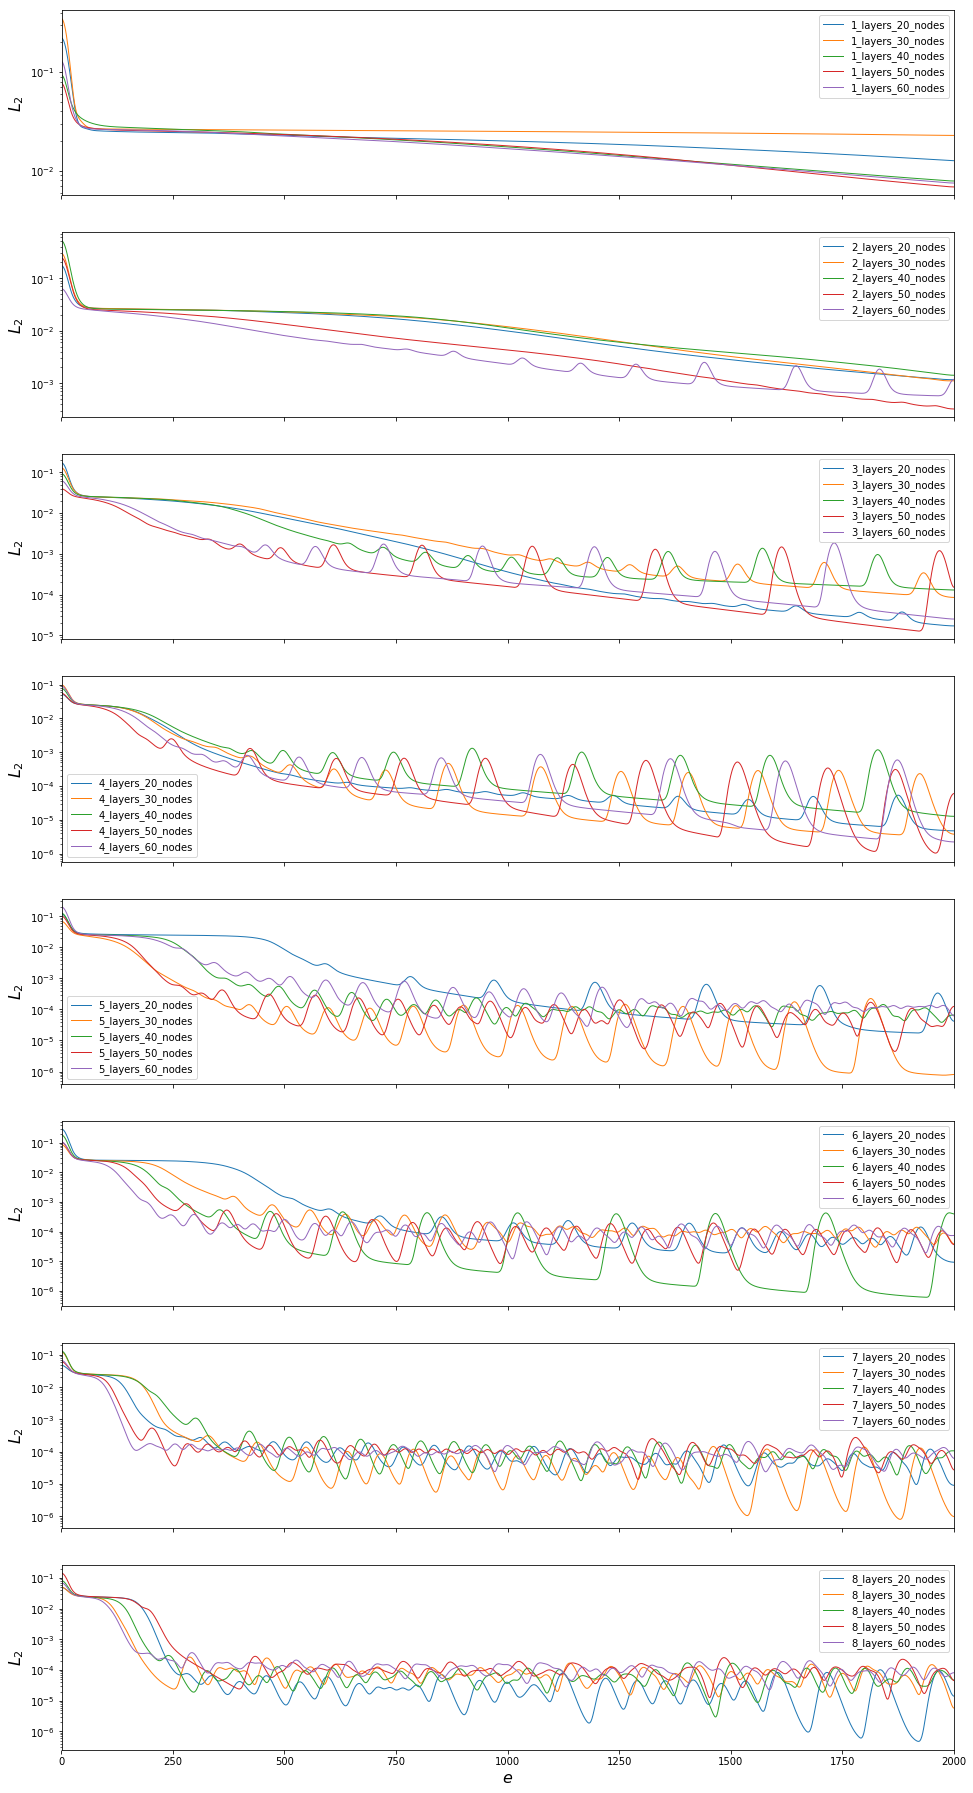

In [13]:
rc('text', usetex=False)
fig, axarr = plt.subplots(len(layers), 1, figsize=(hm.figure_width, 32), sharex=True)

phi_eval = torch.from_numpy(phi.astype(np.float64)).unsqueeze_(-1)
all_metrics = {}

for l in layers:
    for key in all_losses.keys():
        if "{:1d}_layers_".format(l) in key:
            smoothed = gaussian_filter1d(all_losses[key], sigma=10)
            axarr[l-1].plot(range(1, epochs+1), smoothed, lw=1, label=key.split("_selu_")[-1][:-3])
            # some metrics
            rad_eval = all_models[key].forward(phi_eval).detach().squeeze().numpy()
            diff = np.absolute(rad - rad_eval)
            all_metrics[key] = [np.min(all_losses[key]), np.mean(diff), np.max(diff), np.max(diff/rad)]
    axarr[l-1].set_ylabel("$L_2$", fontsize=16)
    axarr[l-1].set_yscale('log')
    axarr[l-1].set_xlim(1, epochs+1)
    
axarr[-1].set_xlabel("$e$", fontsize=16)
axarr[-1].set_xlim(1, epochs+1)
for ax in axarr: ax.legend()

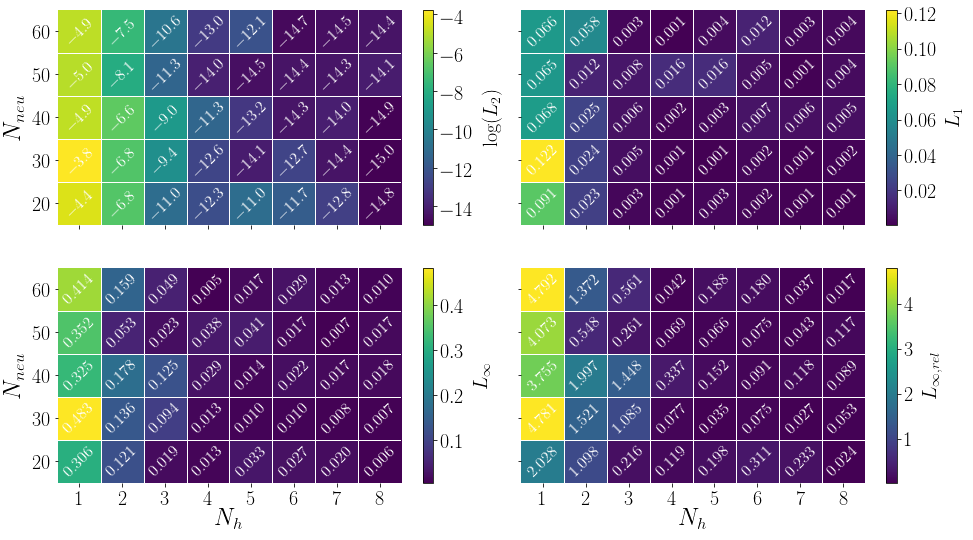

In [14]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 8.7), sharex=True, sharey=True)
xtick_labels = [r"${:1d}$".format(l) for l in layers]
ytick_labels = [r"${:2d}$".format(n) for n in nodes[::-1]]
metric_labels = [r"$\mathrm{log}(L_2)$", r"$L_1$", r"$L_{\infty}$", r"$L_{\infty ,rel}$"]
count = 0
for row in range(2):
    for col in range(2):
        if count is 0:
            metric = np.log(np.asarray(list(all_metrics.values()))[:,count]).reshape(8, 5)[:,::-1].T
        else:
            metric = np.asarray(list(all_metrics.values()))[:,count].reshape(8, 5)[:,::-1].T
        im = axarr[row, col].imshow(metric)
        cbar = axarr[row, col].figure.colorbar(im, ax=axarr[row, col])
        cbar.ax.set_ylabel(metric_labels[count], rotation=90, va="bottom", fontsize=hm.fontsize_tick, labelpad=30)
        cbar.ax.tick_params(labelsize=hm.fontsize_tick)
        axarr[row, col].set_xticks(range(8))
        axarr[row, col].set_xticks(np.arange(0.5, 7.4, 1.0), minor=True)
        axarr[row, col].set_yticks(range(5))
        axarr[row, col].set_yticks(np.arange(0.5, 4.4, 1.0), minor=True)
        axarr[row, col].set_xticklabels(xtick_labels)
        axarr[row, col].set_yticklabels(ytick_labels)
        axarr[row, col].tick_params(labelsize=hm.fontsize_tick)
        for edge, spine in axarr[row, col].spines.items():
            spine.set_visible(False)
        axarr[row, col].grid(which="minor", color="w", linestyle='-', linewidth=1)
        axarr[row, col].tick_params(which="minor", bottom=False, left=False)
        count += 1
        # errors as text
        if count is 1:
            form = r"${:2.1f}$"
        else:
            form = r"${:1.3f}$"
        for i in range(5):
            for j in range(8):
                text = axarr[row, col].text(j, i, form.format(metric[i, j]),
                ha="center", va="center", color="w", fontsize=16, rotation=45)
                
            

axarr[0,0].set_ylabel(r"$N_{neu}$", fontsize=hm.fontsize_label)
axarr[1,0].set_ylabel(r"$N_{neu}$", fontsize=hm.fontsize_label)
axarr[1,0].set_xlabel(r"$N_{h}$", fontsize=hm.fontsize_label)
axarr[1,1].set_xlabel(r"$N_{h}$", fontsize=hm.fontsize_label)

plt.subplots_adjust(wspace=0.08)
savefig("bhaga_03_l16_selu_architecture_metrics")

### Add data points to enforce symmetry

In [8]:
phi_ext = {}
rad_ext = {}
Np = 10
for i, name in enumerate(names):
    rad, phi = np.array(all_facets[name].get_facets(polar=True))
    phi_order = np.argsort(phi)
    phi_sorted = phi[phi_order]
    rad_sorted = rad[phi_order]
    phi_ext[name] = np.concatenate((-phi_sorted[:Np+1], phi_sorted, 2*np.pi - phi_sorted[-Np:]), axis=0)
    rad_ext[name] = np.concatenate((rad_sorted[:Np+1], rad_sorted, rad_sorted[-Np:]), axis=0)

### Estimate the distribution of points over the polar angle

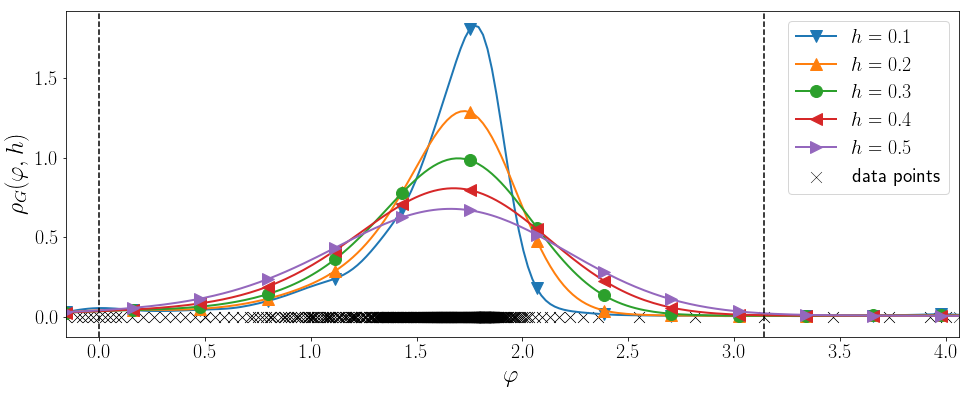

In [9]:
# show influence of bandwidth
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

phi = phi_ext["bhaga_03_l16"]
phi_plot = np.linspace(np.min(phi), np.max(phi), 200)
marker = ["v", "^", "o", "<", ">"]

for i, bw in enumerate(np.linspace(0.1, 0.5, 5)):
    # sklearn formula
    # scale = (phi-1.0)
    # den = np.mean(np.exp(-np.square(scale)/bw**2/2))/bw/np.sqrt(2*np.pi)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(phi[:,np.newaxis])
    log_dens = kde.score_samples(phi[:,np.newaxis])
    density = np.exp(log_dens)
    log_dens = kde.score_samples(phi_plot[:,np.newaxis])
    ax.plot(phi_plot, np.exp(log_dens), lw=2, marker=marker[i], markevery=15, ms=12, label=r"$h={:2.1f}$".format(bw))

ax.scatter(phi, np.zeros(phi.shape[0]), marker="x", color="k", s=120, lw=0.5, label="data points")
ax.axvline(0.0, ls="--", color="k")
ax.axvline(np.pi, ls="--", color="k")
ax.set_xlim(np.min(phi), np.max(phi))
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\rho_G(\varphi ,h)$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)
savefig("bhaga_03_l16_gaussian_density")

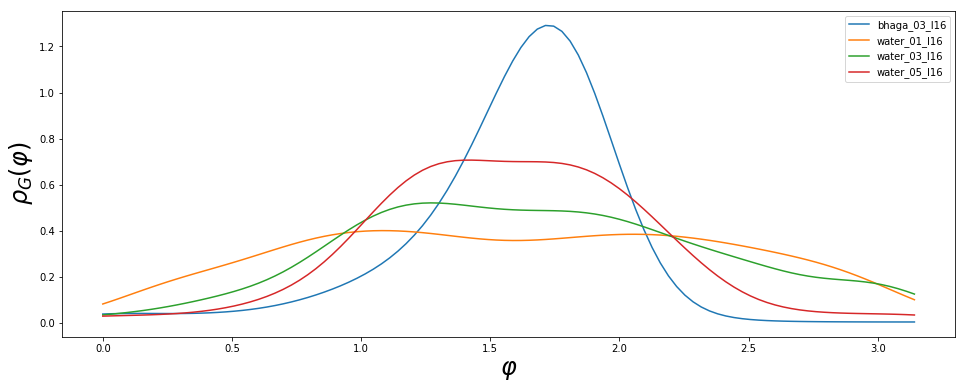

In [10]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

densities_01 = {}

phi_plot = np.linspace(0.0, np.pi, 100)
for i, name in enumerate(names):
    #_, phi = np.array(all_facets[name].get_facets(polar=True))
    phi = phi_ext[name]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(phi[:,np.newaxis])
    log_dens = kde.score_samples(phi[:,np.newaxis])
    density = np.exp(log_dens)
    densities_01[name] = (density - np.min(density)) / (np.max(density) - np.min(density))
    log_dens = kde.score_samples(phi_plot[:,np.newaxis])
    ax.plot(phi_plot, np.exp(log_dens), label=name)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\rho_G (\varphi)$", fontsize=hm.fontsize_label)
ax.legend()

### Define weighting factors for data points according to density

In [11]:
def density_based_weighting(density, alpha):
    return alpha + (1.0 - alpha) * density

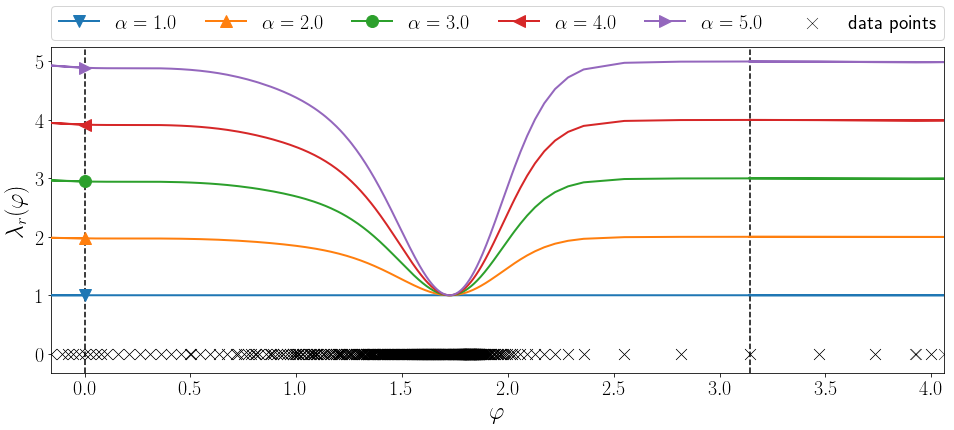

In [12]:
rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

phi = phi_ext["bhaga_03_l16"]
density = densities_01["bhaga_03_l16"]
phi_plot = np.linspace(np.min(phi), np.max(phi), 200)
marker = ["v", "^", "o", "<", ">"]

for i, alpha in enumerate(np.linspace(1, 5, 5)):
    lr = density_based_weighting(density, alpha)
    ax.plot(phi, lr, lw=2, marker=marker[i], markevery=2000, ms=12, label=r"$\alpha={:2.1f}$".format(alpha), zorder=6)

ax.scatter(phi, np.zeros(phi.shape[0]), marker="x", color="k", s=120, lw=0.5, label="data points")
ax.axvline(0.0, ls="--", color="k")
ax.axvline(np.pi, ls="--", color="k")
ax.set_xlim(np.min(phi), np.max(phi))
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\lambda_r(\varphi)$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("bhaga_03_l16_weighting_function")

In [13]:
def evaluate_metrics(m_dict, alpha, radius, phi):
    model = hm.SimpleMLP(**m_dict)
    model_path = output_path + "/" + name + "alpha{:2.0f}".format(alpha) + "_best.pt"
    model.load_state_dict(torch.load(model_path))
    rad_model = model.forward(torch.from_numpy(phi.astype(np.float64)).unsqueeze(-1)).detach().squeeze().numpy()
    rad_model = rad_model * (np.max(radius) - np.min(radius)) + np.min(radius)
    diff = np.absolute(radius - rad_model)
    return np.asarray([np.mean(np.square(diff)), np.mean(diff), np.max(diff), np.max(diff/radius)])

In [19]:
# Note: this cell takes roughly 2h on a workstation with Intel i7
model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

epochs = 2000
name = "bhaga_03_l16"
rad = rad_ext[name]
phi = phi_ext[name]
rad_norm = (rad - np.min(rad)) / (np.max(rad) - np.min(rad))
b_density = densities_01[name]
metrics = {}
repeat = 100

for i, alpha in enumerate(np.linspace(1, 5, 5)):
    print("Test training with alpha={:2.2f}".format(alpha))
    rad_weight = density_based_weighting(b_density, alpha)
    model_path = output_path + "/" + name + "alpha{:2.0f}".format(alpha) + "_best.pt"
    metrics[str(alpha)] = []
    for j in range(repeat):
        model = hm.SimpleMLP(**model_dict)
        rad_weight = density_based_weighting(b_density, alpha)
        model_path = output_path + "/" + name + "alpha{:2.0f}".format(alpha) + "_best.pt"
        model, losses = training_loop(model, model_path, phi, rad_norm, rad_weight, epochs, 0.001)
        metrics[str(alpha)].append(evaluate_metrics(model_dict, alpha, rad, phi))

Test training with alpha=1.00
Test training with alpha=2.00
Test training with alpha=3.00
Test training with alpha=4.00
Test training with alpha=5.00


In [20]:
for i, alpha in enumerate(np.linspace(1, 5, 5)):
    c_metric = np.array(metrics[str(alpha)])
    print("Training statistics for alpha={:2.2f} based on {} repetitions:".format(alpha, repeat))
    print("L2 mean/std:       {:2.4e} \u00B1 {:2.4e}".format(np.mean(c_metric[:,0]), np.std(c_metric[:,0])))
    print("L1 mean/std:       {:2.4e} \u00B1 {:2.4e}".format(np.mean(c_metric[:,1]), np.std(c_metric[:,1])))
    print("Lmax mean/std:     {:2.4e} \u00B1 {:2.4e}".format(np.mean(c_metric[:,2]), np.std(c_metric[:,2])))
    print("Lmax,rel mean/std: {:2.4e} \u00B1 {:2.4e}".format(np.mean(c_metric[:,3]), np.std(c_metric[:,3])))
    print("-"*50)

Training statistics for alpha=1.00 based on 100 repetitions:
L2 mean/std:       4.7990e-06 ± 3.5396e-06
L1 mean/std:       1.0551e-03 ± 4.0878e-04
Lmax mean/std:     2.3663e-02 ± 5.5289e-03
Lmax,rel mean/std: 1.8167e-01 ± 5.9969e-02
--------------------------------------------------
Training statistics for alpha=2.00 based on 100 repetitions:
L2 mean/std:       5.3566e-06 ± 4.3384e-06
L1 mean/std:       1.2126e-03 ± 4.6286e-04
Lmax mean/std:     2.0326e-02 ± 4.1977e-03
Lmax,rel mean/std: 1.4919e-01 ± 3.8489e-02
--------------------------------------------------
Training statistics for alpha=3.00 based on 100 repetitions:
L2 mean/std:       7.7677e-06 ± 6.3922e-06
L1 mean/std:       1.5002e-03 ± 5.5925e-04
Lmax mean/std:     1.8051e-02 ± 3.5349e-03
Lmax,rel mean/std: 1.2759e-01 ± 3.1524e-02
--------------------------------------------------
Training statistics for alpha=4.00 based on 100 repetitions:
L2 mean/std:       1.1295e-05 ± 7.4158e-06
L1 mean/std:       1.8441e-03 ± 6.0423e-04
L

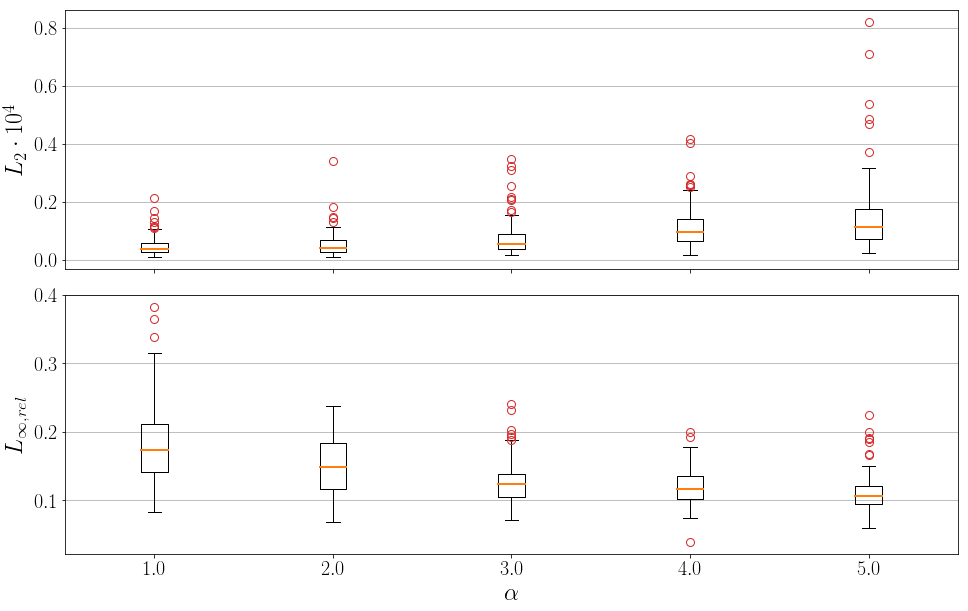

In [78]:
rc('text', usetex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(hm.figure_width, 10), sharex=True)
fig.subplots_adjust(hspace=0.1)

for i, alpha in enumerate(np.linspace(1, 5, 5)):
    c_metric = np.array(metrics[str(alpha)])
    ax1.boxplot(c_metric[:,0]*1e4, positions=[alpha], flierprops={"markersize":8, "markeredgecolor":"C3"},
                medianprops={"linewidth":2, "color":"C1"})
    ax2.boxplot(c_metric[:,3], positions=[alpha], flierprops={"markersize":8, "markeredgecolor":"C3"},
                medianprops={"linewidth":2, "color":"C1"})
    #ax.scatter(np.ones(c_metric.shape[0])*alpha, c_metric[:,3], marker="x", s=100, lw=0.5)
    
ax1.ticklabel_format(axis="y", style="sci")
ax1.tick_params(labelsize=hm.fontsize_tick)
ax1.yaxis.grid(True, linestyle='-', which='major')
ax1.set_ylabel(r"$L_{2}\cdot 10^{4}$", fontsize=hm.fontsize_label)
ax2.set_xlabel(r"$\alpha$", fontsize=hm.fontsize_label)
ax2.set_ylabel(r"$L_{\infty,rel}$", fontsize=hm.fontsize_label)
ax2.tick_params(labelsize=hm.fontsize_tick)
ax2.set_xticks([1, 2, 3, 4, 5])
ax2.set_xticklabels([r"${:2.1f}$".format(a) for a in np.linspace(1, 5, 5)])
ax2.set_xlim(0.5, 5.5)
ax2.yaxis.grid(True, linestyle='-', which='major')
savefig("alpha_influence_boxplot")

Minimal loss:  1.51154836871e-05
Minimal loss:  4.27756350311e-06
Minimal loss:  8.36481351482e-06
Minimal loss:  8.60777724182e-06


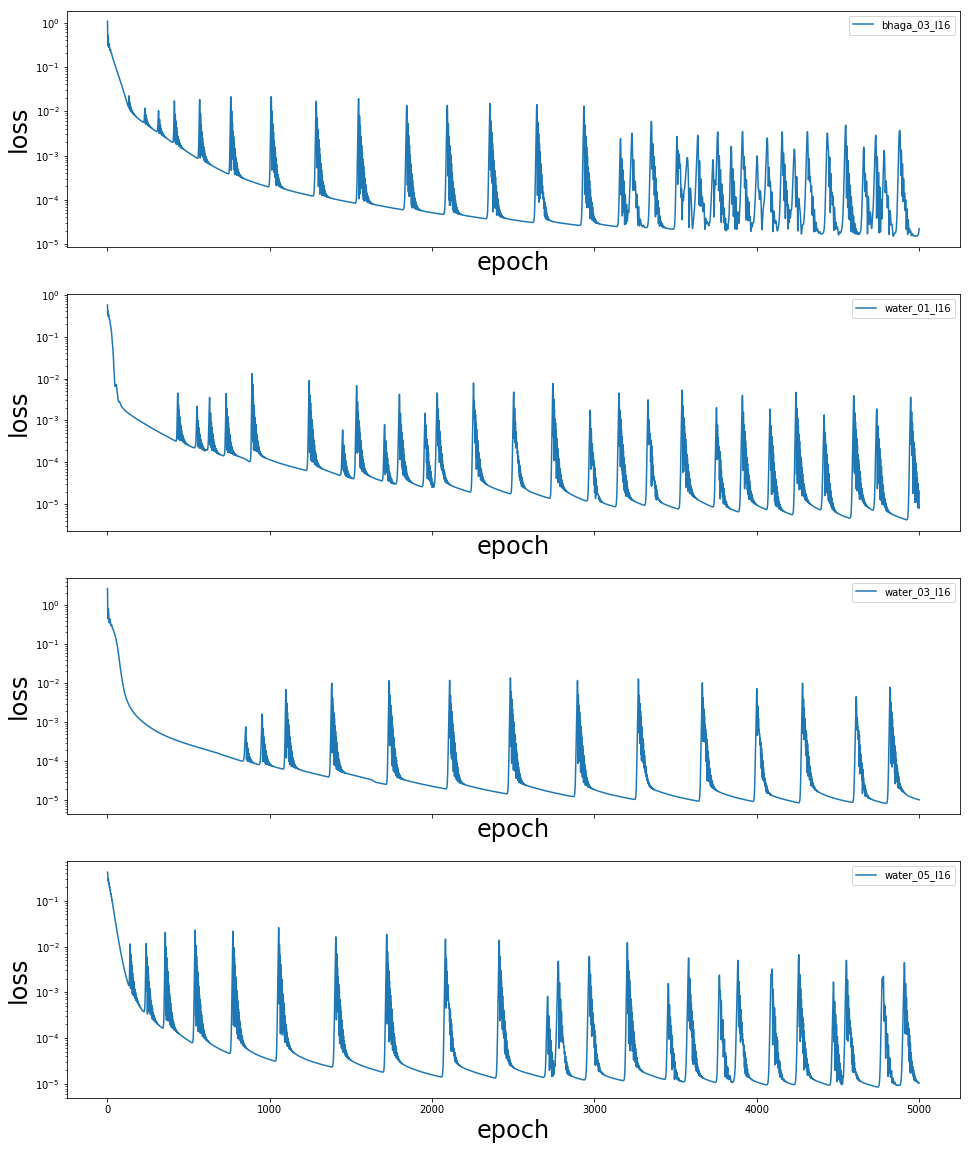

In [65]:
rc('text', usetex=False)
fig, axarr = plt.subplots(len(names), 1, figsize=(hm.figure_width, len(names)*5), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

epochs = 5000
for i, name in enumerate(names):
    model = hm.SimpleMLP(**model_dict)
    rad = rad_ext[name]
    phi = phi_ext[name]
    rad_norm = (rad - np.min(rad)) / (np.max(rad) - np.min(rad))
    rad_weight = density_based_weighting(densities_01[name], 5)
    model_path = output_path + "/" + name + "_selu_best.pt"
    model, losses = training_loop(model, model_path, phi, rad_norm, rad_weight, epochs, 0.001)
    print("Minimal loss: ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name)
    axarr[i].set_xlabel("epoch", fontsize=hm.fontsize_label)
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()

In [66]:
def format_exp_latex(number):
    expo = int(np.floor(np.log10(abs(number))))
    latex = "{:2.4f}".format(number/10**expo) + "e^{" + "{:02d}".format(expo) + "}"
    return latex

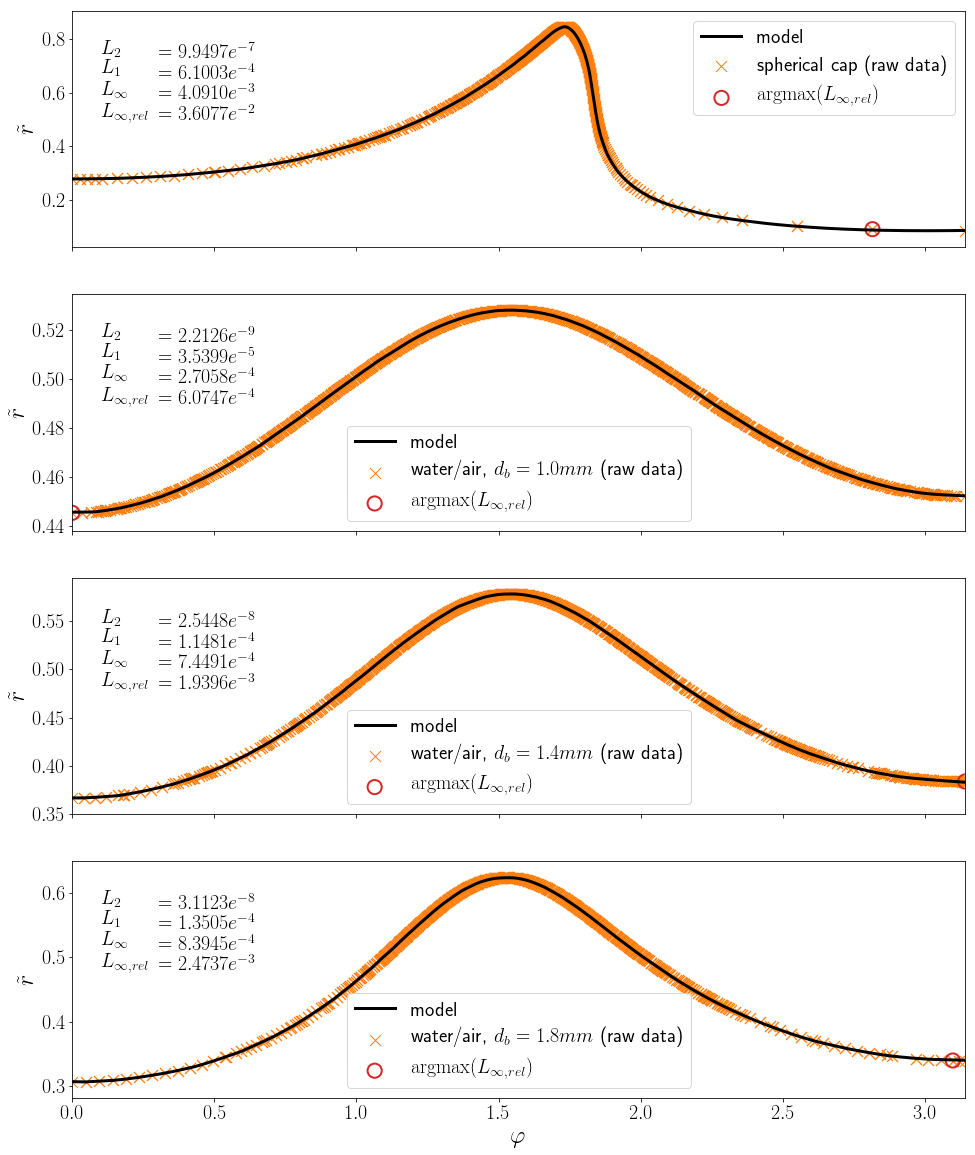

In [67]:
rc('text', usetex=True)

fig, axarr = plt.subplots(4, 1, figsize=(hm.figure_width, 20), sharex=True)
labels = ["spherical cap", "water/air, $d_b=1.0mm$", "water/air, $d_b=1.4mm$", "water/air, $d_b=1.8mm$"]

y_pos = [0.5, 0.49, 0.48, 0.48]

for i, name in enumerate(names):
    model = hm.SimpleMLP(**model_dict)
    rad, phi = all_facets[name].get_facets(polar=True)
    model_path = output_path + "/" + name + "_selu_best.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 400)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    rad_eval = rad_eval * (np.max(rad) - np.min(rad)) + np.min(rad)
    
    rad_model = model.forward(torch.from_numpy(phi.astype(np.float64)).unsqueeze(-1)).detach().squeeze().numpy()
    rad_model = rad_model * (np.max(rad) - np.min(rad)) + np.min(rad)
    diff = np.absolute(rad - rad_model)
    axarr[i].text(0.1, y_pos[i], "$L_2$\n$L_1$\n$L_\infty$\n$L_{\infty,rel}$", fontsize=hm.fontsize_tick)
    axarr[i].text(0.3, y_pos[i], "$=" + format_exp_latex(np.mean(np.square(diff))) + "$\n"
                  + "$=" + format_exp_latex(np.mean(diff)) + "$\n"
                  + "$=" + format_exp_latex(np.max(diff)) + "$\n"
                  + "$=" + format_exp_latex(np.max(diff/rad)) + "$", fontsize=hm.fontsize_tick)
    
    axarr[i].plot(phi_eval.squeeze(), rad_eval, color="k", lw=hm.line_width, label="model")
    axarr[i].scatter(phi, rad, marker="x", s=120, lw=1, color="C1", label="{} (raw data)".format(labels[i]))
    axarr[i].scatter([phi[np.argmax(diff/rad)]],[rad[np.argmax(diff/rad)]],
                     marker="o", facecolors='none', edgecolors='C3', s=200, lw=2,
                     label="$\mathrm{argmax}(L_{\infty ,rel})$")
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
savefig("basilisk_2D_simple_shape_final")

## Export shapes as stl

In [68]:
height = 0.1
eval_phi = np.linspace(0.0, np.pi, 400)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

for i, name in enumerate(names):
    rad, _ = all_facets[name].get_facets(polar=True)
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/" + name + "_selu_best.pt"
    model.load_state_dict(torch.load(model_path))
    rad_model = model.forward(phi_tensor).detach().squeeze().numpy()
    rad_model = rad_model * (np.max(rad) - np.min(rad)) + np.min(rad)
    
    x, y = hm.transform_cartesian_2D(rad_model, eval_phi)
    tri_list = []
    for t in range(len(x)-1):
        # upper triangle
        tri_list.append(hm.Triangle(np.asarray([x[t], y[t], 0.0]),
                                    np.asarray([x[t+1], y[t+1], height]),
                                    np.asarray([x[t], y[t], height]))
                        )
        # lower triangle
        tri_list.append(hm.Triangle(np.asarray([x[t], y[t], 0.0]),
                                    np.asarray([x[t+1], y[t+1], 0.0]),
                                    np.asarray([x[t+1], y[t+1], height]))
                         )
    path = "../output/STL/" + name + ".stl"
    hm.triangles_to_stl(path, "bubble", tri_list)
    print("Exported file {}".format(path))

Exported file ../output/STL/bhaga_03_l16.stl
Exported file ../output/STL/water_01_l16.stl
Exported file ../output/STL/water_03_l16.stl
Exported file ../output/STL/water_05_l16.stl
